# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v6</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

- rolling average
- finite-diff.'s gradient
- GP $\propto$ deriv. of control signal (using piecewise values corresponding to analytic)
- fixed-step integration
- apply to step test

## Change Log
- This files is derived from `pyomo_tclab_v5c.ipynb`
- First implementation of optimization in Pyomo

## Setup

In [1]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [2]:
data = pd.read_csv(os.path.join(dir, "tclab_sine_test.csv"))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [3]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

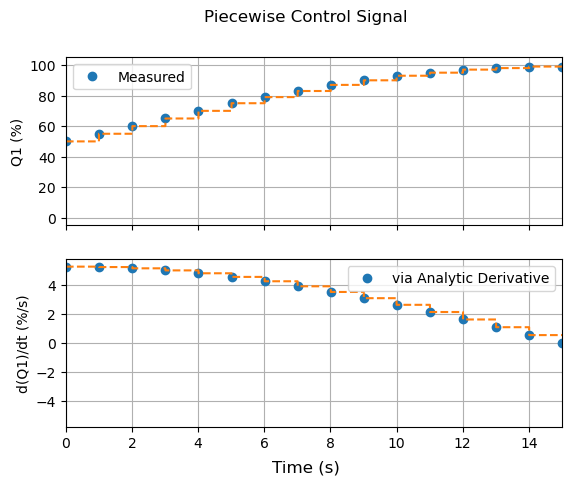

In [4]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [5]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [6]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

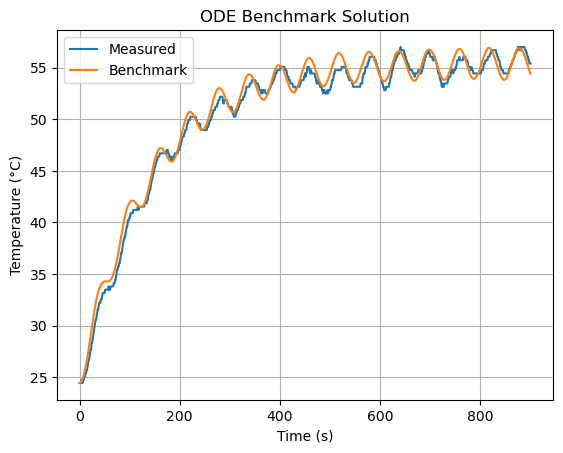

In [7]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a rolling average as the smoothing function,

In [8]:
window = 9  # odd number, mean at center +/- floor(window/2))

In [9]:
def smooth(TS1, window):
    """Apply centered average of size window."""
    TS1_smooth = np.zeros_like(TS1)
    w2 = int(np.floor(window / 2))
    w2p1 = w2 + 1

    # bleed in:
    for i in range(w2):
        TS1_smooth[i] = np.mean(TS1[:(i + w2p1)])

    # center:
    for i in range(w2, TS1_smooth.size - w2):
        TS1_smooth[i] = np.mean(TS1[(i - w2):(i + w2p1)])

    # bleed out:
    for i in range(-w2, 0):
        TS1_smooth[i] = np.mean(TS1[(i - w2)::])

    return TS1_smooth

TS1_smooth = smooth(TS1, window)

### Derivative

In [10]:
def gradient_h4(x, h):
    """h is step size. Order of error is h^4."""
    dx = np.zeros_like(x)

    # bleed in:
    h2 = 2 * h
    dx[0] = (x[1] - x[0]) / h
    dx[1] = (x[2] - x[0]) / h2

    # center difference:
    h12 = 12 * h
    for i in range(2, x.shape[0] - 2):
        dx[i] = (x[i - 2] - 8 * x[i - 1] + 8 * x[i + 1] - x[i + 2]) / h12
    
    # bleed out:
    dx[-2] = (x[-1] - x[-3]) / h2
    dx[-1] = (x[-1] - x[-2]) / h

    return dx

dTS1 = gradient_h4(TS1_smooth, tvec[1] - tvec[0])
dTS1f = interp1d(tvec, dTS1, kind='previous')  # piecewise, grab previous value

Plotting training data:

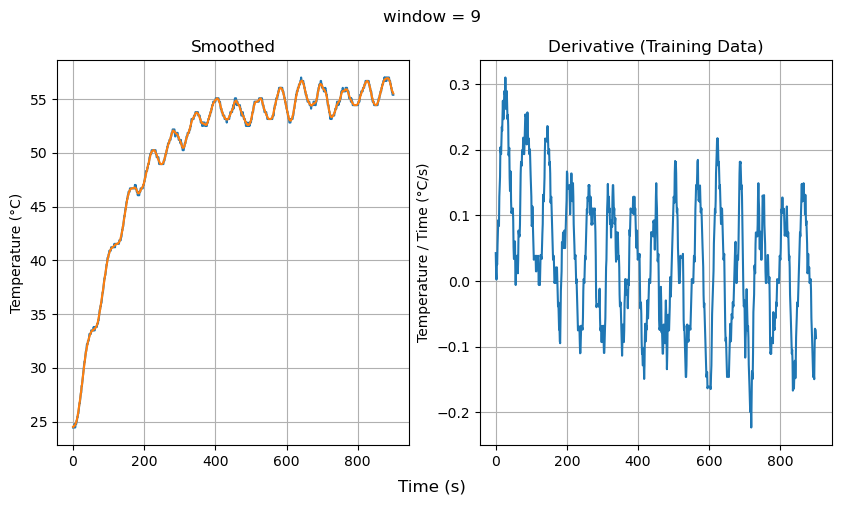

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"window = {window}")
fig.supxlabel("Time (s)")

axs[0].plot(TS1)
axs[0].plot(TS1_smooth)
axs[0].set_title("Smoothed")
axs[0].set_ylabel("Temperature (°C)")
axs[0].grid()

axs[1].plot(dTS1)
axs[1].set_title("Derivative (Training Data)")
axs[1].set_ylabel("Temperature / Time (°C/s)")
axs[1].grid()

Validation of training data:

In [12]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec, first_step=1, min_step=1, max_step=1)

/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


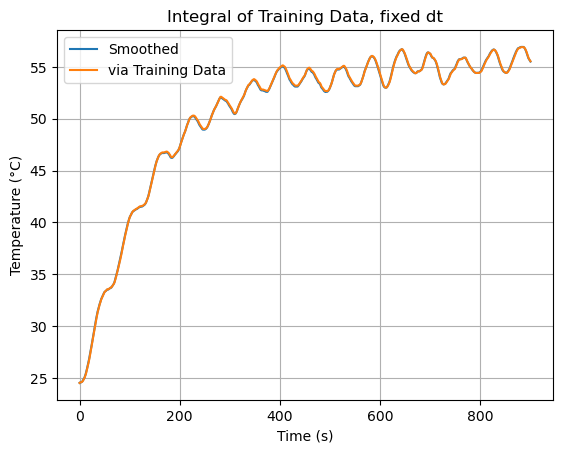

In [13]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data, fixed dt')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

In [14]:
GP_dT = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_dT.fit([TS1_smooth, dQ1f(tvec)], dTS1, clean=True)

[1, -4743.770751535982]
[2, -4742.162753192983]
[2, -4788.446617303]
[3, -4799.100762652352]
[3, -4801.9618148012605]
[4, -4801.9618148012605]
[4, -4801.9618148012605]
[4, -4804.41226569077]
[5, -4809.972818670285]
[5, -4811.113075237977]
[5, -4828.87451562835]
[6, -4828.87451562835]
[6, -4833.347561662446]
[6, -4833.347561662446]
[6, -4833.815082013626]
[7, -4844.664928076782]
[7, -4847.25533235577]
[7, -4847.25533235577]
[7, -4851.347462076131]
[8, -4851.347462076131]
[8, -4851.347462076131]
[8, -4861.044092740406]
[8, -4861.044092740406]
[8, -4861.044092740406]
[9, -4861.044092740406]


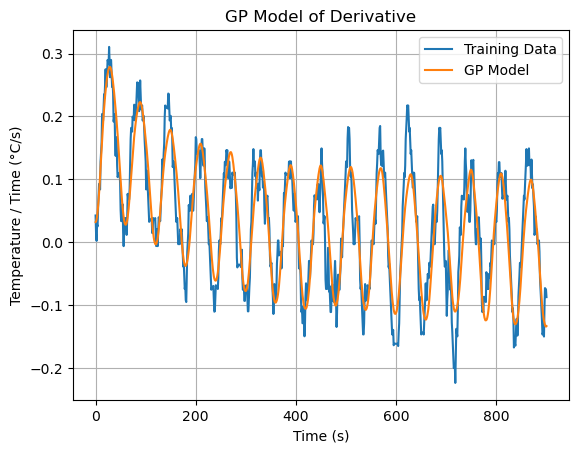

In [15]:
dTS1_GP = GP_dT.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec, dTS1_GP)
plt.title("GP Model of Derivative")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

Validation of GP model:

In [16]:
dt = tvec[1] - tvec[0]  # assume constant time step

def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], dQ1f(t)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[0], tvec[-1]], [TS1_smooth[0]], 'LSODA', tvec, first_step=1, min_step=1, max_step=1)

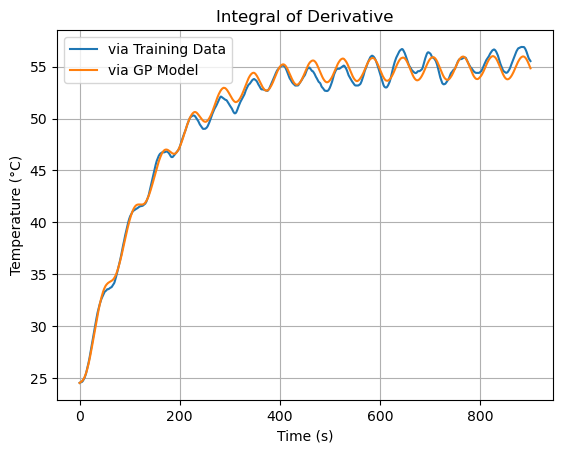

In [17]:
TS1_GP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_training)
plt.plot(tvec, TS1_GP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['via Training Data', 'via GP Model'])
plt.grid()

## Benchmark Comparison

In [18]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

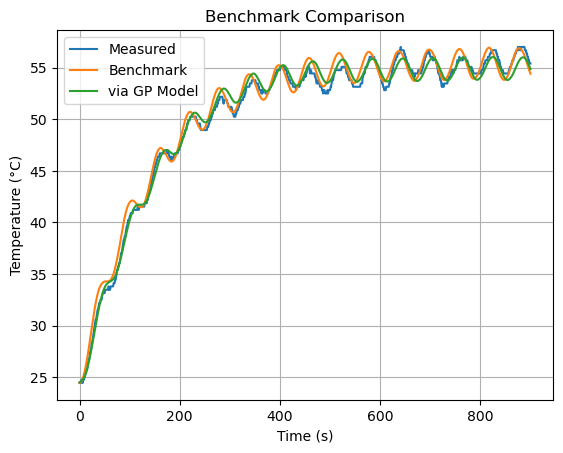

In [19]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.plot(tvec, TS1_GP)
plt.title('Benchmark Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark = _rmse(TS1, TS1_benchmark)
RMSE_GP = _rmse(TS1, TS1_GP)

# print(f"\
# | Method       | RMSE |\n\
# |--------------|------|\n\
# | Benchmark    | {"{0:0.2f}".format(round(RMSE_benchmark, 2))} |\n\
# | via GP Model | {"{0:0.2f}".format(round(RMSE_GP, 2))} |")

## Controller Reference Trajectory

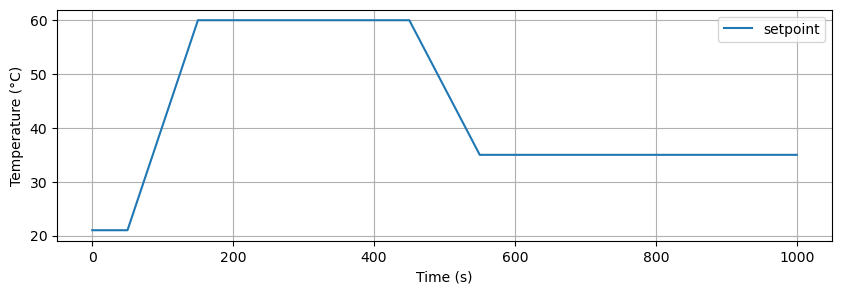

In [20]:
import numpy as np

# time grid
tf = 1000
dt = 2
n = round(tf / dt)
t_grid = np.linspace(0, 1000, n + 1)

# ambient temperature
Tamb = 21


# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])


# plot the setpoint function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel("Time (s)")
ax.legend()
ax.grid(True)


## Optimization in Python using Benchmark Model

Reference: https://dowlinglab.github.io/pyomo-doe/notebooks/pyomo_simulation.html#controlling-to-a-reference-tractory

In [21]:
# import Pyomo library
import pyomo.environ as pyo
import pyomo.dae as dae

# parameters
alpha = 0.00016  # watts / (units P * percent U1)
P = 200  # P units
Ua = 0.050  # heat transfer coefficient from heater to environment
CpH = 2.2  # heat capacity of the heater (J/deg C)
CpS = 1.9  # heat capacity of the sensor (J/deg C)
Ub = 0.021  # heat transfer coefficient from heater to sensor
Tamb = 21.0  # ambient temperature

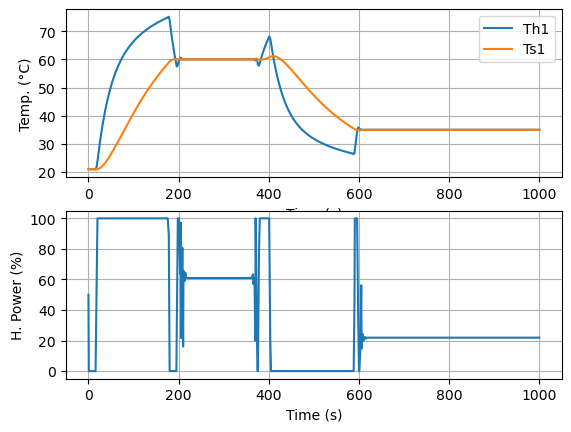

In [22]:
# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th1 = pyo.Var(m.t)
m.Ts1 = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh1 = dae.DerivativeVar(m.Th1)
m.dTs1 = dae.DerivativeVar(m.Ts1)

# Define the control variable (heater power) as a function of time
m.u1 = pyo.Var(m.t, bounds=(0, 100))

# Define the integral of the squared error
# Note: This modified objective tracks the sensor temperature error
# This is important because our GP model is trained on the sensor temperature
# We want to compare apples to apples
@m.Integral(m.t)
def ise(m, t):
    return (r(t) - m.Ts1[t]) ** 2


# Define the first differential equation
@m.Constraint(m.t)
def heater1(m, t):
    return (
        CpH * m.dTh1[t]
        == Ua * (Tamb - m.Th1[t]) + Ub * (m.Ts1[t] - m.Th1[t]) + alpha * P * m.u1[t]
    )


# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub * (m.Th1[t] - m.Ts1[t])


# Fix the initial conditions
m.Th1[0].fix(Tamb)
m.Ts1[0].fix(Tamb)


# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise

# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

def plot_results(m):
    """
    Plot results from Pyomo optimization

    Arguments:
    m: Pyomo model

    Returns:
    Nothing
    
    """

    # Plot the results
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(m.t, [m.Th1[t]() for t in m.t], label="Th1")
    ax[0].plot(m.t, [m.Ts1[t]() for t in m.t], label="Ts1")
    ax[0].legend()
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Temp. (°C)")
    ax[0].grid()

    ax[1].plot(m.t, [m.u1[t]() for t in m.t], label="U1")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("H. Power (%)")
    ax[1].grid()

plot_results(m)

## Optimization using GP Model

In [23]:
# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater with GP Model')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# TODO: Add scenarios here for each draw of the GP model

# TODO: Index this variable by both the number of scenarios and time
# Define the state variables as a function of time
m.Ts1 = pyo.Var(m.t)

# TODO: Index this variable by both the number of scenarios and time
# Define the derivatives of the state variables
m.dTs1 = dae.DerivativeVar(m.Ts1)

# TODO: Index this variable by both the number of scenarios and time
# Define the control variable (heater power) as a function of time
m.u1 = pyo.Var(m.t, bounds=(0, 100))

# TODO: Index this variable by both the number of scenarios and time
# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (r(t) - m.Ts1[t]) ** 2

# TODO: Index this constraint by both the number of scenarios and time
# Define the second differential equation
# TODO: update this with the GP model in the RHS
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub * (m.Th1[t] - m.Ts1[t])

# TODO: Index this variable by both the number of scenarios and time
# Fix the initial conditions
m.Ts1[0].fix(Tamb)

# TODO: Change this objective to average the ISE over all scenarios
# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise


# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

ERROR: Rule failed when generating expression for Constraint sensor1 with
index 0: AttributeError: 'ConcreteModel' object has no attribute 'Th1'
ERROR: Constructing component 'sensor1' from data=None failed:
        AttributeError: 'ConcreteModel' object has no attribute 'Th1'


AttributeError: 'ConcreteModel' object has no attribute 'Th1'